# MTL, Policies, and Experiments
In this file, we're going to be taking a look at what makes MTL hard (gradient conflicts), and how traditional models rely on static or rigid rule based heuristics to resolve them. We will also take a look at why these methods are often unable to converge to the Pareto front, which provides us the incentive to resort to a trained policy model.

---

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity

# Lets create a shared parameter vector (this is our mock "Neural Network")
# Initialized at (0,0)
theta = torch.tensor([0.0, 0.0], requires_grad=True)

print(f"Initial parameters: {theta}")


Initial parameters: tensor([0., 0.], requires_grad=True)


### Simulate Gradient Conflicts
We can define two simple loss functions, lets say:
- Task A wants parameters to move to (2,2)
- Task B wants parameters to move to (-2,-2)

We further multiply Task B's loss by 10.0 to simulate a task that is not only opposing, but also has a larger magnitude.

In [ ]:
def get_task_gradients(theta_input):
    if theta_input.grad is not None:
        theta_input.grad.zero_() # reset the gradients

    # Task A - gradient want to move to (2,2)
    target_A = torch.tensor([2.0, 2.0])
    loss_A = torch.sum((theta_input - target_A) ** 2)
    loss_A.backward(retain_graph=True)

    grad_A = theta_input.grad.clone() #saving the gradient

    
    
    theta_input.grad.zero_() # reset the gradients for Task B again


    # Task B - gradient want to move to (-2,2)
    target_B = torch.tensor([-2.0, -2.0])
    loss_B = torch.sum((theta_input - target_B) ** 2) * 10.0 # magnitude imbalanced!!!
    loss_B.backward(retain_graph=True)

    grad_B = theta_input.grad.clone() # saving the gradient


    return grad_A, grad_B


g_A, g_B = get_task_gradients(theta)

print(f"Task A Gradient: {g_A.numpy()}")
print(f"Task B Gradient: {g_B.numpy()}")



# Cosine similarity between gradients to show they are actually opposing

cos_sim = cosine_similarity(g_A, g_B, dim=0)

print(f"Cosine Similarity between Task A and Task B gradients: {cos_sim}")




Task A Gradient: [-4. -4.]
Task B Gradient: [40. 40.]
Cosine Similarity between Task A and Task B gradients: -0.9999999403953552


The cosine similarity being this close to -1 means the gradients are in the opposing directions!

But lets plot and visually see this as well.

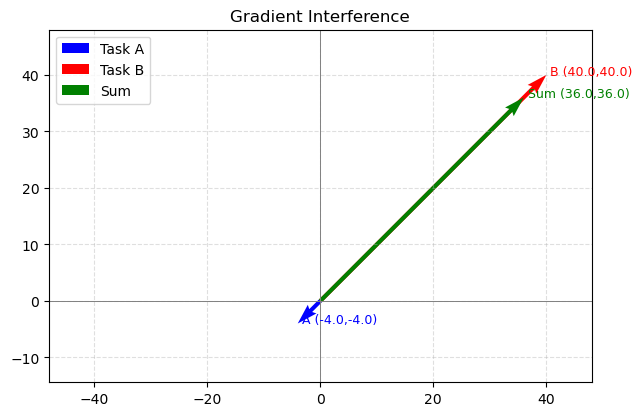

In [41]:
s = g_A + g_B

plt.figure(figsize=(7,7))
plt.axhline(0, color='gray', lw=0.7)
plt.axvline(0, color='gray', lw=0.7)

plt.quiver(0, 0, g_A[0], g_A[1], color='blue', angles='xy', scale_units='xy', scale=1, label='Task A')
plt.quiver(0, 0, g_B[0], g_B[1], color='red', angles='xy', scale_units='xy', scale=1, label='Task B')
plt.quiver(0, 0, s[0], s[1], color='green',angles='xy', scale_units='xy', scale=1, label='Sum')


plt.text(g_A[0], g_A[1], f' A ({g_A[0]},{g_A[1]})', color='blue', fontsize=9)
plt.text(g_B[0], g_B[1], f' B ({g_B[0]},{g_B[1]})', color='red', fontsize=9)
plt.text(s[0], s[1], f' Sum ({s[0]},{s[1]})', color='green',fontsize=9)


lim = max(1.0, np.max(np.abs(np.concatenate([g_A, g_B, s])))) * 1.2
plt.xlim(-lim, lim)
plt.ylim(-0.3*lim, lim)

plt.gca().set_aspect('equal', adjustable='box')

plt.grid(alpha=0.4, linestyle='--')

plt.legend()
plt.title('Gradient Interference')
plt.show()

The Blue arrow is where Task A wants to go. The Red arrow is where Task B wants to go. They are strictly opposed (**Directional Conflict**). However, because Task B has a larger loss scale, the Red arrow is huge. When we simply add them together (Green arrow), the model completely ignores Task A and moves almost exclusively in the direction of Task B (**Magnitude Conflict**)

### Now, lets demonstrate WHY gradient conflicts are such a problem: Negative Transfer!
We will create a training loop to show how combining these tasks hurt performance
- Single Task - training only on task A
- Multi Task - training on both Task A and B

Then we compare the final loss of Task A in both scenarios

In [50]:
def train_model(mode, steps=50):
    # reinit model parameters to 0,0
    theta = torch.tensor([0.0, 0.0], requires_grad=True)

    optimizer = torch.optim.SGD([theta], lr=0.1)

    history_loss_A = []

    for i in range(0, steps):
        optimizer.zero_grad()

        target_A = torch.tensor([2.0, 2.0])
        loss_A = torch.sum((theta - target_A) ** 2)

        target_B = torch.tensor([-2.0, -2.0])
        loss_B = torch.sum((theta - target_B) ** 2) * 10.0 # magnitude imbalanced!!!

        if mode == 'MTL':
            final_loss = loss_A + loss_B
        
        elif mode == 'STL':
            final_loss = loss_A


        final_loss.backward()
        optimizer.step()

        history_loss_A.append(loss_A.item())

    return theta.detach().numpy(), history_loss_A


In [53]:
theta_STL, loss_STL = train_model('STL', steps=50)
print(f"Final parameters after STL training: {theta_STL}")
print(f"Loss history on Task A after STL training: {loss_STL}")

theta_MTL, loss_MTL = train_model('MTL', steps=50)
print(f"\n\nFinal parameters after MTL training: {theta_MTL}")
print(f"Loss history on Task A after MTL training: {loss_MTL}")

Final parameters after STL training: [1.9999715 1.9999715]
Loss history on Task A after STL training: [8.0, 5.12000036239624, 3.2767999172210693, 2.097151756286621, 1.3421770334243774, 0.858993411064148, 0.5497556924819946, 0.3518436849117279, 0.2251800149679184, 0.14411520957946777, 0.09223373234272003, 0.05902959033846855, 0.03777896612882614, 0.024178558960556984, 0.015474260784685612, 0.009903526864945889, 0.006338262464851141, 0.004056496545672417, 0.0025961578357964754, 0.001661546528339386, 0.0010633919155225158, 0.0006805690936744213, 0.0004355614073574543, 0.0002787581761367619, 0.00017840522923506796, 0.0001141779066529125, 7.307501073228195e-05, 4.676846947404556e-05, 2.993181988131255e-05, 1.9156956113874912e-05, 1.2260923540452495e-05, 7.846991138649173e-06, 5.022225650463952e-06, 3.2139823815668933e-06, 2.0568520540109603e-06, 1.3165400787329418e-06, 8.426475233136443e-07, 5.392944331106264e-07, 3.451880559168785e-07, 2.2092035578680225e-07, 1.413383188264561e-07, 9.04565

### Look at the last Loss value for each!

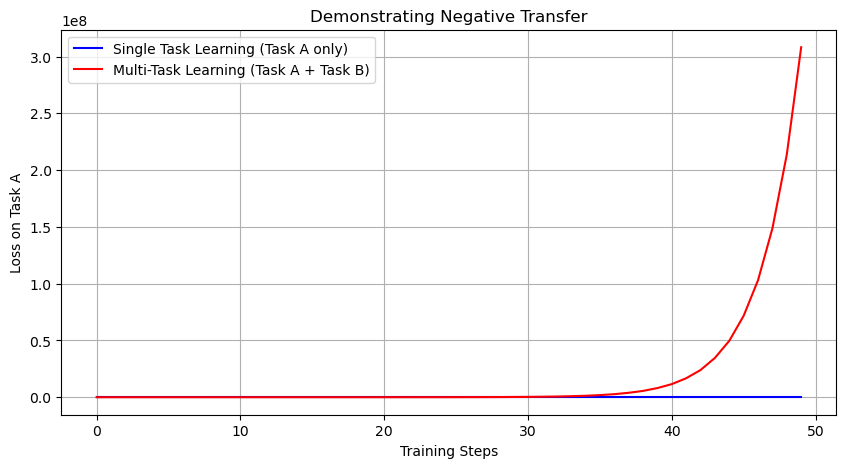

Final Task A Loss (STL): 2.5409292447875487e-09
Final Task A Loss (MTL): 308182784.0
------------------------------
Parameter Position STL: [1.9999715 1.9999715]
Parameter Position MTL: [14890.025 14890.025]


In [57]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(loss_STL, label='Single Task Learning (Task A only)', color='blue')
plt.plot(loss_MTL, label='Multi-Task Learning (Task A + Task B)', color='red')
plt.xlabel('Training Steps')
plt.ylabel('Loss on Task A')
plt.title('Demonstrating Negative Transfer')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Task A Loss (STL): {loss_STL[-1]}")
print(f"Final Task A Loss (MTL): {loss_MTL[-1]:}")
print("-" * 30)
print(f"Parameter Position STL: {theta_STL}")
print(f"Parameter Position MTL: {theta_MTL}")

In the Blue line (STL), we trained only on Task A, and the loss went to zero (perfect convergence).

In the Red line (MTL), we tried to learn both. Because of the Gradient Interference we visualized earlier, the model was pulled away from Task A's goal.

The final loss for Task A is significantly higher in the MTL setting. This gap between the Blue and Red lines is the definition of Negative Transfer. The presence of Task B actively hurt the learning of Task A.